In [42]:
import os
import math
import random
import time
import re
from tqdm import tqdm
import glob
import ast
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from transformers import AutoTokenizer
from transformers import AutoModel
from transformers import AutoConfig
from transformers import get_cosine_schedule_with_warmup
from transformers import get_linear_schedule_with_warmup

import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
russian_stopwords = stopwords.words("russian")
import matplotlib.pyplot as plt
import gc
gc.enable()

In [2]:
def set_random_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    os.environ["PYTHONHASHSEED"] = str(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
set_random_seed(13)

In [3]:
class CFG:
    model = "DeepPavlov/rubert-base-cased"
    epochs = 5
    lr_bert = 1e-5
    lr_nn = 1e-4
    batch_size = 16
    max_len = 512
    n_fold = 4
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
df_train = pd.read_parquet("dataset/train_dataset_train_full_proc.parquet")

In [5]:
df_train['views'] = (df_train['views'] - df_train['views'].min()) / (df_train['views'].max() - df_train['views'].min())
df_train['depth'] = df_train['depth'] - 1
df_train['full_reads_percent'] = df_train['full_reads_percent'] / 100

In [6]:
class RBKDataset(Dataset):
    def __init__(self, df, inference_only=False):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(f"{CFG.model}")
        self.df = df        
        self.inference_only = inference_only
        self.text = df.full_text_original.tolist()
        
        if not self.inference_only:
            self.views = torch.tensor(df.views, dtype=torch.float32)  
            self.depth = torch.tensor(df.depth, dtype=torch.float32) 
            self.full_reads_percent = torch.tensor(df.full_reads_percent, dtype=torch.float32)  
    
        self.encoded = self.tokenizer.batch_encode_plus(
            self.text, 
            padding = 'max_length', 
            max_length = CFG.max_len,
            add_special_tokens=True,
            truncation = True,
            return_attention_mask = True
        )
   
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):        
        input_ids = torch.tensor(self.encoded['input_ids'][index])
        attention_mask = torch.tensor(self.encoded['attention_mask'][index])
        
        if self.inference_only:
            return {
                'input_ids': input_ids,
                'attention_mask': attention_mask
            }           
        else:
            views = self.views[index]
            depth = self.depth[index]
            full_reads_percent = self.full_reads_percent[index]
            return {
                'input_ids': input_ids,
                'attention_mask': attention_mask,
                'target': torch.stack([views, depth, full_reads_percent], dim=0)
            }

In [7]:
class RBKModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.config = AutoConfig.from_pretrained(f"{CFG.model}")
        self.rubert = AutoModel.from_pretrained(f"{CFG.model}", config=self.config)  
        self.attention = nn.Sequential(            
                                            nn.Linear(768, 128),            
                                            nn.Tanh(),                       
                                            nn.Linear(128, 1),
                                            nn.Softmax(dim=1)
                                        )
  
        self.fc1 = nn.Linear(self.config.hidden_size, 100)
        self.dropout = nn.Dropout(0.25)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100, 3)
    
    def forward(self, input_ids, attention_mask):
        rubert_output = self.rubert(input_ids=input_ids,
                                      attention_mask=attention_mask)
        weights = self.attention(rubert_output['last_hidden_state'])
        context_vector = torch.sum(weights * rubert_output['last_hidden_state'], dim=1)
        fc1 = self.fc1(context_vector)
        logits = self.fc2(self.relu(self.dropout(fc1)))
        return {'logits': logits,
               'context_vector': fc1}
    
    
    

In [8]:
def mertic_for_task(pred, target):
    score_views = r2_score(target[:,0], pred[:,0])
    score_depth = r2_score(target[:,1], pred[:,1])
    score_frp = r2_score(target[:,2], pred[:,2])
    return 0.4 * score_views + 0.3 * score_depth + 0.3 * score_frp

In [9]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.cumulate_pred = []
        self.cumulate_target = []
    
    def cumulate_metrics(self, pred, target):
        self.cumulate_pred.extend(pred)
        self.cumulate_target.extend(target)
        
    def return_avg_metric(self):
        return mertic_for_task(np.array(self.cumulate_pred), np.array(self.cumulate_target))
        
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
    

In [10]:
def train_net(loader, epoch, opt, tr_loss, model):
    print(f"Epoch {epoch+1}")
    model.train()
    stream = tqdm(loader)
    AverageTrain = AverageMeter()
    for i, batch in enumerate(stream, start=1):
        opt.zero_grad()
        pred = model(batch['input_ids'].to(CFG.device), 
                     batch['attention_mask'].to(CFG.device)
                    )['logits']
        loss = tr_loss(pred, batch['target'].to(CFG.device))
        loss.backward()
        opt.step()
        AverageTrain.update(loss.item())
        AverageTrain.cumulate_metrics(pred.cpu().detach().numpy(), 
                                         batch['target'].detach().numpy())
    print(f"Loss on train {AverageTrain.avg} R2 {AverageTrain.return_avg_metric()}")
    return model, AverageTrain.avg, AverageTrain.return_avg_metric()

In [11]:
def val_net(loader, tr_loss, model):
    all_pred = []
    all_target = []
    
    model.eval()
    AverageTest = AverageMeter()
    stream = tqdm(loader)
    for i, batch in enumerate(stream, start=1):
        with torch.set_grad_enabled(False):
            pred = model(batch['input_ids'].to(CFG.device), 
                         batch['attention_mask'].to(CFG.device)
                        )['logits']
            loss = tr_loss(pred, batch['target'].to(CFG.device))
        AverageTest.update(loss.item())
        AverageTest.cumulate_metrics(pred.cpu().detach().numpy(), 
                                         batch['target'].detach().numpy())
    
    
    print(f"Loss on test {AverageTest.avg} R2 {AverageTest.return_avg_metric()}")
    return AverageTest.avg, AverageTest.return_avg_metric()

In [12]:
def create_optimizer(model):
    parameters = []
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    for name_layer, params in list(model.named_parameters()):
        if 'rubert' in name_layer:
            lr = CFG.lr_bert
            if any(nd in name_layer for nd in no_decay):
                weight_decay = 0.01
            else:
                weight_decay = 0.0
            
            parameters.append({"params": params,
                               "weight_decay": weight_decay,
                               "lr": lr})
        else:
            lr = CFG.lr_nn
            if any(nd in name_layer for nd in no_decay):
                weight_decay = 0.0
            else:
                weight_decay = 0.0
            parameters.append({"params": params,
                               "weight_decay": weight_decay,
                               "lr": lr})
    return torch.optim.Adam(parameters)

In [13]:
def run():
    metrics = {}
    for fold in range(4):
        _loss_train, _loss_test, _R2_train, _R2_test = [], [], [], []
        with open(f'utils/splits/test_fold_{fold}.pkl', 'rb') as handle:
            test_index = pickle.load(handle)
        with open(f'utils/splits/train_fold_{fold}.pkl', 'rb') as handle:
            train_index = pickle.load(handle)
        best_metric = 0
        tr_loss = torch.nn.MSELoss(reduction="mean")
        model = RBKModel().to(CFG.device)
        opt = create_optimizer(model)
        train_loader = DataLoader(
            RBKDataset(df_train.iloc[train_index].reset_index()), 
            batch_size=CFG.batch_size, 
            shuffle=True
        )
        val_loader = DataLoader(
            RBKDataset(df_train.iloc[test_index].reset_index()), 
            batch_size=CFG.batch_size, 
            shuffle=False
        )
        for epoch in range(CFG.epochs):
            model, loss_train, metric_train = train_net(train_loader, epoch, opt, tr_loss, model)
            _loss_train.append(loss_train)
            _R2_train.append(metric_train)
            loss_test, metric_test = val_net(val_loader, tr_loss, model)
            _loss_test.append(loss_test)
            _R2_test.append(metric_test)
            if metric_test > best_metric:
                best_metric = metric_test
                torch.save(model.state_dict(), f"models_bert/rbk_bert_model_{fold}.pth")
        metrics[fold] = [_loss_train, _R2_train, _loss_test, _R2_test]
        gc.collect()
        torch.cuda.empty_cache()
    return metrics


In [14]:
if __name__== "__main__":
    metircs_nn = run()

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1


100%|██████████| 328/328 [03:20<00:00,  1.64it/s]


Loss on train 0.006276642843348361 R2 -0.6217239617393829


100%|██████████| 110/110 [00:22<00:00,  4.96it/s]


Loss on test 0.0048883378706787795 R2 0.04509574212119075
Epoch 2


100%|██████████| 328/328 [03:24<00:00,  1.60it/s]


Loss on train 0.004827611336467515 R2 -0.20594864820280867


100%|██████████| 110/110 [00:22<00:00,  4.87it/s]


Loss on test 0.004417223545764996 R2 0.1482078957154171
Epoch 3


100%|██████████| 328/328 [03:27<00:00,  1.58it/s]


Loss on train 0.004400170981747712 R2 -0.07728695395821136


100%|██████████| 110/110 [00:22<00:00,  4.84it/s]


Loss on test 0.004193161313676022 R2 0.2037378251762754
Epoch 4


100%|██████████| 328/328 [03:25<00:00,  1.60it/s]


Loss on train 0.003887184536036263 R2 0.0700248009519276


100%|██████████| 110/110 [00:22<00:00,  4.90it/s]


Loss on test 0.0038482156592759896 R2 0.29428982869182896
Epoch 5


100%|██████████| 328/328 [03:26<00:00,  1.59it/s]


Loss on train 0.0034544145544315123 R2 0.13230013751240138


100%|██████████| 110/110 [00:22<00:00,  4.97it/s]


Loss on test 0.003830129688140005 R2 0.276415371005748


Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1


100%|██████████| 328/328 [03:26<00:00,  1.59it/s]


Loss on train 0.0064445488032794035 R2 -0.39497081143548585


100%|██████████| 110/110 [00:22<00:00,  4.90it/s]


Loss on test 0.003827118868304586 R2 0.0011471011379710488
Epoch 2


100%|██████████| 328/328 [03:27<00:00,  1.58it/s]


Loss on train 0.005202333749521796 R2 -0.07203748645576467


100%|██████████| 110/110 [00:22<00:00,  4.90it/s]


Loss on test 0.0034117870022204112 R2 0.10943509245040162
Epoch 3


100%|██████████| 328/328 [03:27<00:00,  1.58it/s]


Loss on train 0.004618689271964974 R2 0.06082259632140093


100%|██████████| 110/110 [00:22<00:00,  4.92it/s]


Loss on test 0.003325169419192455 R2 -0.005232168199521978
Epoch 4


100%|██████████| 328/328 [03:27<00:00,  1.58it/s]


Loss on train 0.004222879716175291 R2 0.1251397297287693


100%|██████████| 110/110 [00:22<00:00,  4.82it/s]


Loss on test 0.0031722013468176804 R2 0.14429870467533285
Epoch 5


100%|██████████| 328/328 [03:23<00:00,  1.61it/s]


Loss on train 0.0037420234751529857 R2 0.21354502901410083


100%|██████████| 110/110 [00:22<00:00,  4.99it/s]


Loss on test 0.003309807393022559 R2 0.07871110477541536


Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1


100%|██████████| 328/328 [03:24<00:00,  1.61it/s]


Loss on train 0.005844339402534477 R2 -0.3228665879697008


100%|██████████| 110/110 [00:22<00:00,  5.00it/s]


Loss on test 0.004597410136325793 R2 0.08689477614110722
Epoch 2


100%|██████████| 328/328 [03:21<00:00,  1.62it/s]


Loss on train 0.004779537818848905 R2 -0.0368483148058938


100%|██████████| 110/110 [00:21<00:00,  5.02it/s]


Loss on test 0.003821033347313377 R2 0.20119094478526584
Epoch 3


100%|██████████| 328/328 [03:21<00:00,  1.63it/s]


Loss on train 0.004122945387058369 R2 0.10373999786756395


100%|██████████| 110/110 [00:21<00:00,  5.01it/s]


Loss on test 0.003735133793882348 R2 0.2218148141263278
Epoch 4


100%|██████████| 328/328 [03:21<00:00,  1.63it/s]


Loss on train 0.0037525778642724973 R2 0.19377845223154716


100%|██████████| 110/110 [00:21<00:00,  5.01it/s]


Loss on test 0.0038264967808076603 R2 0.19876742825058866
Epoch 5


100%|██████████| 328/328 [03:21<00:00,  1.63it/s]


Loss on train 0.0032884995215260084 R2 0.24482019078858763


100%|██████████| 110/110 [00:21<00:00,  5.01it/s]


Loss on test 0.004356257504233243 R2 0.17625941930823702


Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1


100%|██████████| 328/328 [03:20<00:00,  1.63it/s]


Loss on train 0.0070365299747563986 R2 -0.5711070456122581


100%|██████████| 110/110 [00:21<00:00,  5.00it/s]


Loss on test 0.004439235983458771 R2 0.08416641186836832
Epoch 2


100%|██████████| 328/328 [03:21<00:00,  1.63it/s]


Loss on train 0.005528754235256645 R2 -0.19253126237296744


100%|██████████| 110/110 [00:21<00:00,  5.01it/s]


Loss on test 0.0035359028599817642 R2 0.15014390409284428
Epoch 3


100%|██████████| 328/328 [03:21<00:00,  1.63it/s]


Loss on train 0.004900961762603667 R2 -0.048208109114885225


100%|██████████| 110/110 [00:22<00:00,  4.95it/s]


Loss on test 0.003295084491202777 R2 0.23585551327292156
Epoch 4


100%|██████████| 328/328 [03:21<00:00,  1.63it/s]


Loss on train 0.004399377107336299 R2 0.059735402465789414


100%|██████████| 110/110 [00:21<00:00,  5.02it/s]


Loss on test 0.0030933053402060814 R2 0.31500884034125853
Epoch 5


100%|██████████| 328/328 [03:21<00:00,  1.63it/s]


Loss on train 0.003991567697972286 R2 0.1404380296451929


100%|██████████| 110/110 [00:21<00:00,  5.02it/s]


Loss on test 0.003445523662958294 R2 0.26283201434578585


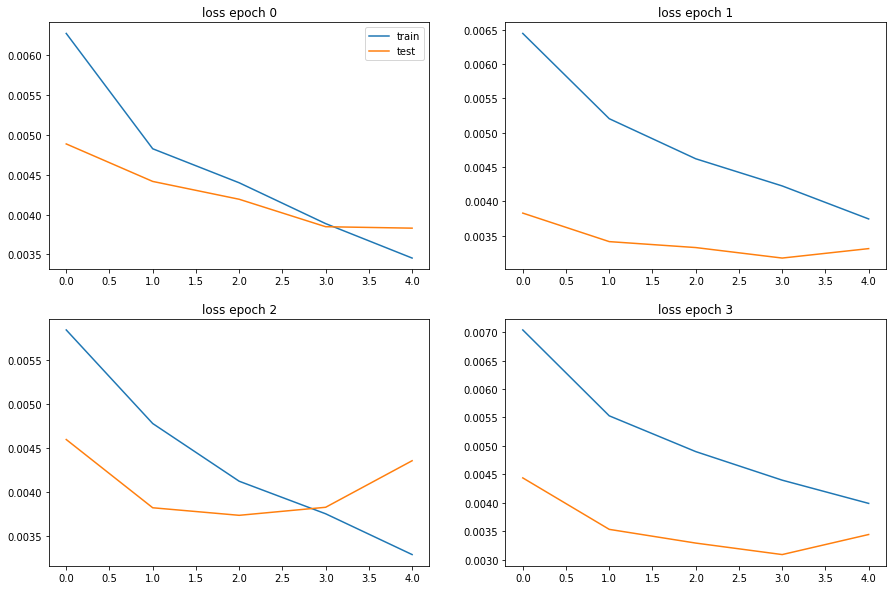

In [66]:
x = range(5)
fig, axs = plt.subplots(2, 2)
fig.set_figheight(10)
fig.set_figwidth(15)
axs[0, 0].plot(x, metircs_nn[0][0] ,label='train')
axs[0, 0].plot(x, metircs_nn[0][2], label='test')
axs[0, 0].set_title('loss epoch 0')
axs[0, 0].legend()
axs[0, 1].plot(x, metircs_nn[1][0], label='train')
axs[0, 1].plot(x, metircs_nn[1][2], label='test')
axs[0, 1].set_title('loss epoch 1')
axs[1, 0].plot(x, metircs_nn[2][0], label='train')
axs[1, 0].plot(x, metircs_nn[2][2], label='test')
axs[1, 0].set_title('loss epoch 2')
axs[1, 1].plot(x, metircs_nn[3][0], label='train')
axs[1, 1].plot(x, metircs_nn[3][2], label='test')
axs[1, 1].set_title('loss epoch 3')
plt.show()